## This notebook is for preparing pipeline for the dataset.

In [1]:
import torch
from torch.utils.data import Dataset
import cv2
import albumentations as A
from pycocotools.coco import COCO
import numpy as np

class LiveCellDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms # The Albumentations pipeline

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        # 1. Get Image Info
        img_id = self.ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        
        # 2. Load Image (Handle the subfolder logic here)
        cell_type = file_name.split('_')[0]
        img_path = f"{self.root_dir}/{cell_type}/{file_name}"
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 3. Generate Target (Mask)
        # Get annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Create a mask (Binary or Instance depending on your model)
        # This creates a mask where 1=Cell, 0=Background
        mask = np.zeros((img_info['height'], img_info['width']))
        for ann in anns:
            mask = np.maximum(mask, self.coco.annToMask(ann))

        # 4. Apply Augmentations (Image AND Mask together)
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # 5. Normalize (0-1) and Convert to Tensor
        image = image / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1).float() # Channels first
        mask = torch.from_numpy(mask).long()
        return image, mask


In [2]:
train_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_train.json')
test_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_test_images",annotation_file='jsons/livecell_coco_test.json')
val_dataset = LiveCellDataset(root_dir = "dataset/images 2/livecell_train_val_images",annotation_file='jsons/livecell_coco_val.json')

loading annotations into memory...
Done (t=4.91s)
creating index...
index created!
loading annotations into memory...
Done (t=2.23s)
creating index...
index created!
loading annotations into memory...
Done (t=1.55s)
creating index...
index created!


In [3]:
import cv2
import matplotlib.pyplot as plt

In [4]:
image, mask = train_dataset[0]

Display an image and a mask

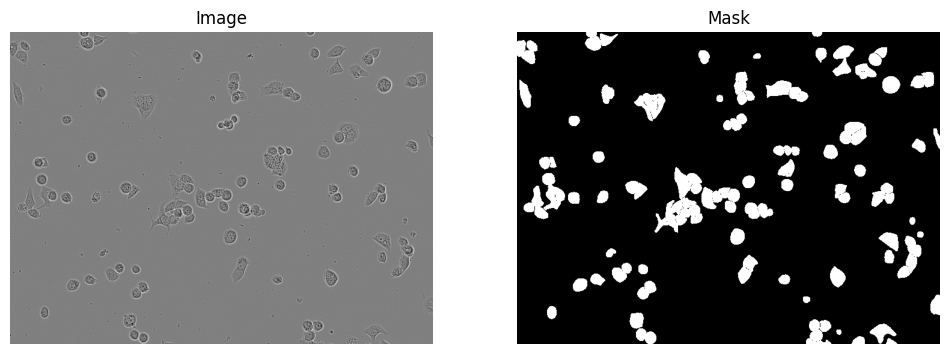

In [5]:
# 1. If 'image' is a Tensor, move it to CPU and rearrange dimensions
# From (3, 520, 704) -> (520, 704, 3)
image_to_show = image.permute(1, 2, 0).cpu().numpy()

# 2. If 'mask' is a Tensor with a channel dim (e.g., 1, 520, 704), flatten it
# From (1, 520, 704) -> (520, 704)
if len(mask.shape) == 3:
    mask_to_show = mask.squeeze().cpu().numpy()
else:
    mask_to_show = mask.cpu().numpy()

# --- Plotting ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_to_show)
plt.title("Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mask_to_show, cmap='gray') # Use gray cmap for masks
plt.title("Mask")
plt.axis('off')

plt.show()

## EDA

In [6]:
import os
from collections import defaultdict
import seaborn as sns

In [7]:
ANNOTATION_DIR = 'jsons'

In [8]:
def perform_deep_eda(info_json_path, type):
    json_path = os.path.join(ANNOTATION_DIR, info_json_path)
    if not os.path.exists(json_path):
        print(f"Error: File not found at {json_path}")
        return

    print("Loading JSON... (This takes memory!)")
    coco = COCO(json_path)
    
    # Containers for stats
    cell_counts_per_image = []
    cell_areas = []
    cell_types_count = defaultdict(int)
    
    img_ids = coco.getImgIds()
    print(f"Analyzing {len(img_ids)} images...")

    for i_id in img_ids:
        # 1. Get basic image info
        img_info = coco.loadImgs(i_id)[0]
        filename = img_info['file_name']
        
        # Identify Cell Type from filename (e.g. 'A172_Phase_...')
        c_type = filename.split('_')[0]
        cell_types_count[c_type] += 1
        
        # 2. Get Annotations for this image
        ann_ids = coco.getAnnIds(imgIds=i_id)
        anns = coco.loadAnns(ann_ids)
        
        # Store Count (Density)
        cell_counts_per_image.append(len(anns))
        
        # Store Areas (Size)
        for ann in anns:
            cell_areas.append(ann['area'])

    # ================= PLOTTING =================
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Class Distribution
    types = list(cell_types_count.keys())
    counts = list(cell_types_count.values())
    sns.barplot(x=types, y=counts, ax=axes[0], palette="viridis")
    axes[0].set_title(f"Image Count per Cell Type for {type}")
    axes[0].set_ylabel(f"Number of Images for {type}")
    axes[0].tick_params(axis='x', rotation=45)

    # Plot 2: Cell Density (Counts per Image)
    sns.histplot(cell_counts_per_image, bins=50, kde=True, ax=axes[1], color="orange")
    axes[1].set_title(f"Cell Density Distribution : {type}")
    axes[1].set_xlabel("Number of Cells in Image")
    axes[1].axvline(np.mean(cell_counts_per_image), color='r', linestyle='--', label=f'Mean: {int(np.mean(cell_counts_per_image))}')
    axes[1].legend()

    # Plot 3: Cell Size Distribution (Box Area)
    # Filter huge outliers for better visualization (99th percentile)
    limit = np.percentile(cell_areas, 99)
    filtered_areas = [a for a in cell_areas if a < limit]
    
    sns.histplot(filtered_areas, bins=50, kde=True, ax=axes[2], color="green")
    axes[2].set_title(f"Cell Size Distribution (pixels^2)")
    axes[2].set_xlabel("Area (pixels)")
    axes[2].axvline(np.mean(filtered_areas), color='r', linestyle='--', label=f'Mean Area: {int(np.mean(filtered_areas))}')
    axes[2].legend()

    plt.tight_layout()
    plt.savefig(f"eda_summary_plots_{type}.png") # Saves to disk for your report
    print(f"Plots saved as eda_summary_plots_{type}.png")
    plt.show()
    
    print(f"\n==={type}===")
    print(f"Total Images: {len(img_ids)}")
    print(f"Total Annotations: {len(cell_areas)}")
    print(f"Average Cells per Image: {np.mean(cell_counts_per_image):.2f}")
    print(f"Average Cell Area: {np.mean(cell_areas):.2f} pixels")
    print(f"Smallest Cell Area: {np.min(cell_areas)} pixels")

### EDA for Training Annotations and Samples

Loading JSON... (This takes memory!)
loading annotations into memory...
Done (t=5.88s)
creating index...
index created!
Analyzing 3253 images...


/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_12425/2203428002.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=types, y=counts, ax=axes[0], palette="viridis")


Plots saved as eda_summary_plots_TRAIN.png


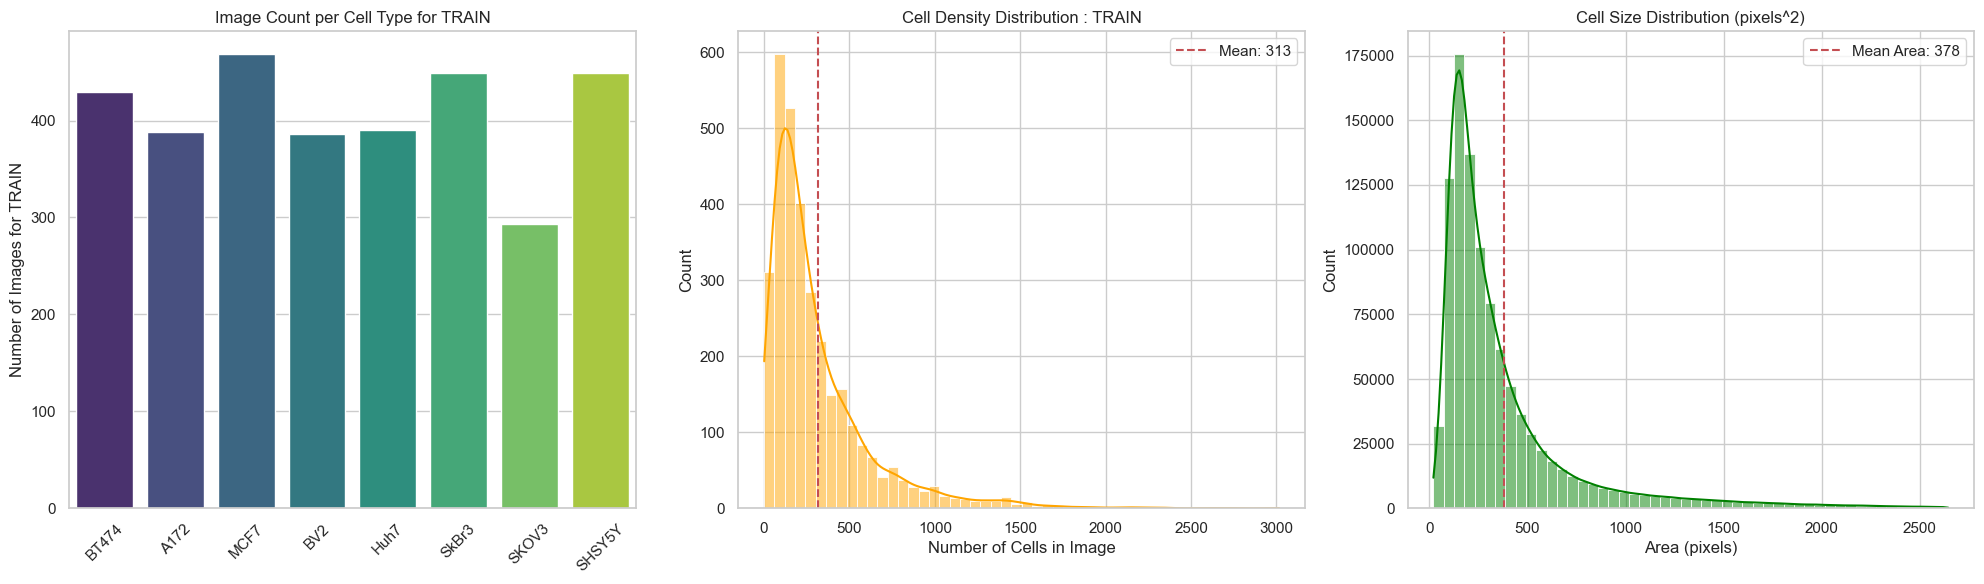


===TRAIN===
Total Images: 3253
Total Annotations: 1018576
Average Cells per Image: 313.12
Average Cell Area: 413.90 pixels
Smallest Cell Area: 20.03890000001411 pixels


In [9]:
perform_deep_eda('livecell_coco_train.json','TRAIN')

### EDA for Validation Annotations and Images

Loading JSON... (This takes memory!)
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
Analyzing 570 images...


/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_48721/2203428002.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=types, y=counts, ax=axes[0], palette="viridis")


Plots saved as eda_summary_plots_VALIDATION.png


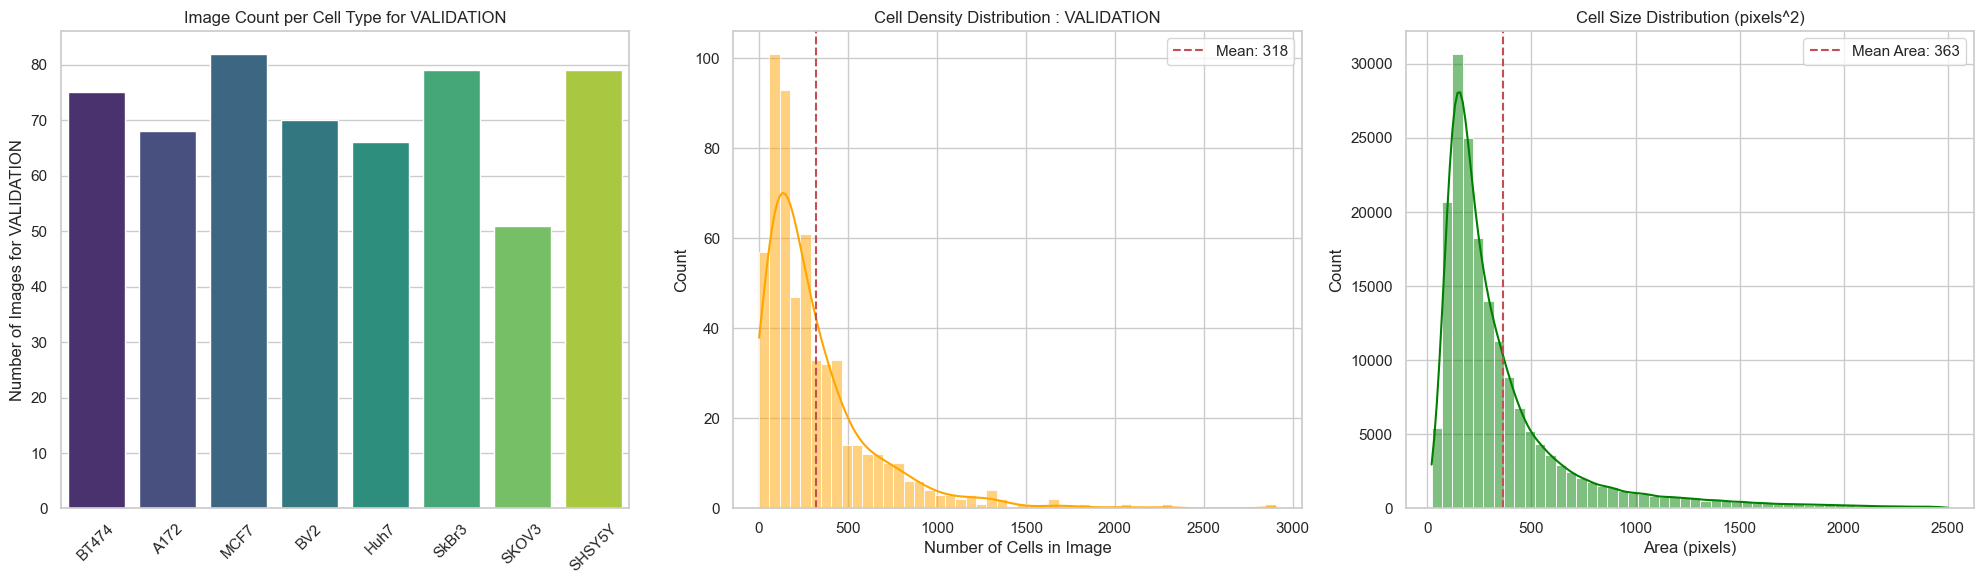


===VALIDATION===
Total Images: 570
Total Annotations: 181610
Average Cells per Image: 318.61
Average Cell Area: 396.59 pixels
Smallest Cell Area: 20.14494999999988 pixels


In [20]:
perform_deep_eda('livecell_coco_val.json','VALIDATION')

### EDA for Testing Annotations and Images

Loading JSON... (This takes memory!)
loading annotations into memory...
Done (t=2.64s)
creating index...
index created!
Analyzing 1564 images...


/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_48721/2203428002.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=types, y=counts, ax=axes[0], palette="viridis")


Plots saved as eda_summary_plots_TEST.png


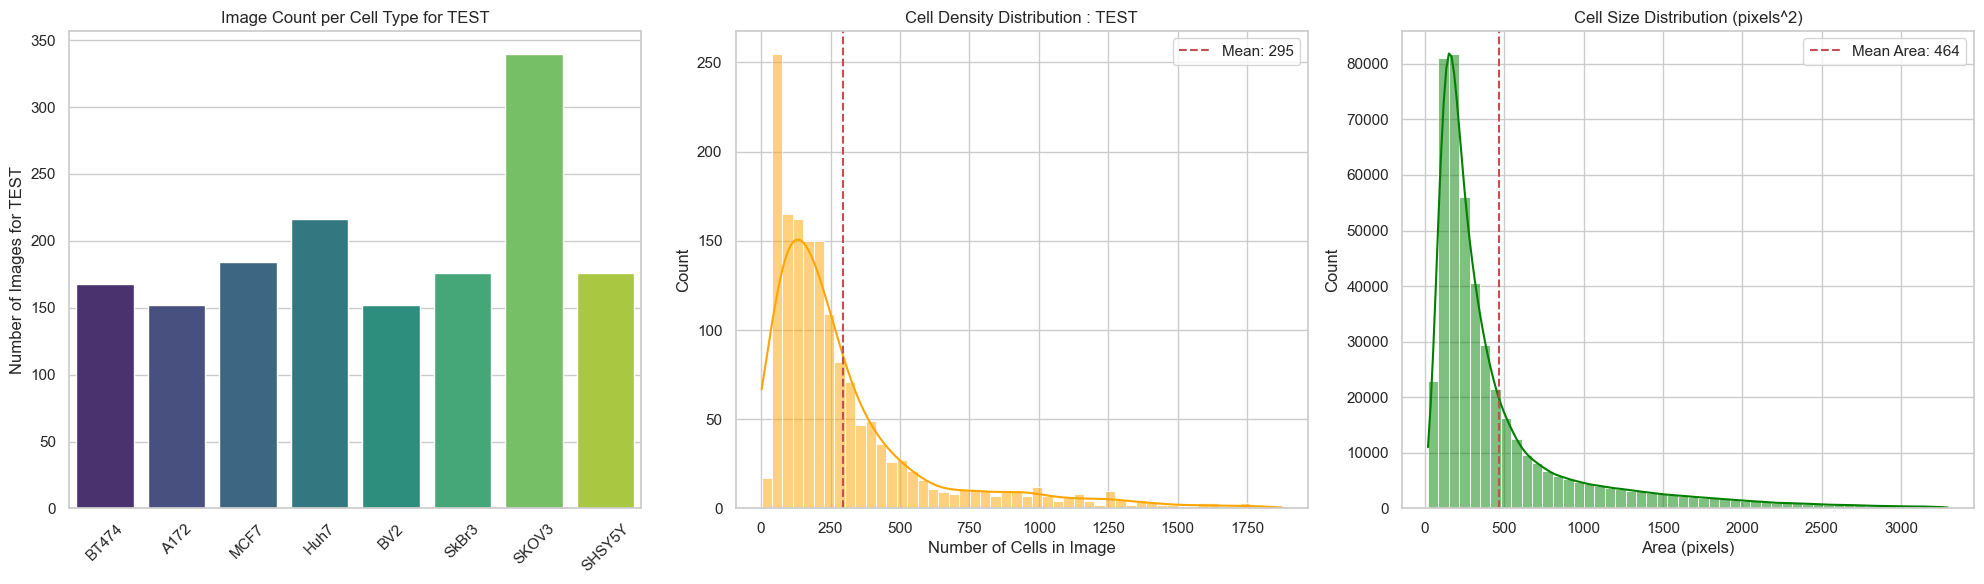


===TEST===
Total Images: 1564
Total Annotations: 462261
Average Cells per Image: 295.56
Average Cell Area: 507.51 pixels
Smallest Cell Area: 20.009599999990314 pixels


In [21]:
perform_deep_eda("livecell_coco_test.json","TEST")

### Analysis of what can be observed in the images

1. **Number of images per cell category** - While the Training and Validation sets share a similar distribution, the Test set exhibits a distributional shift, particularly with an over-representation of SKOV3. Implication: If the model overfits to SKOV3 features (likely due to its higher frequency), the final Test accuracy might be artificially inflated. Conversely, under-represented classes in the training set might suffer lower recall during testing. This justifies monitoring class-specific metrics during evaluation.

2. **Dataset Sizes** - The Training set contains ~313 annotations/image, whereas the Test set drops to ~295. This slight drop in density in the Test set suggests it might contain more ‘sparse’ images, potentially making it slightly easier for object separation than the training phase

3. **Average Cells per Image** - The average density of ~313 cells per image is exceptionally high compared to standard datasets like COCO (which averages ~7 objects per image). Implication: This high density confirms that occlusion and boundary merging will be the primary failure modes. Standard global resizing (e.g., to 640x640) would likely cause massive information loss for such dense clusters, validating our hypothesis that a Tiled Inference strategy is required.

4. **Object Scale Variance**: Analysis of the bounding box areas reveals that the average cell occupies only ~20 pixels. This places the LIVECell task firmly in the ‘Small Object Detection’ domain, where standard CNN backbones (like ResNet50) often struggle due to downsampling layers losing spatial information.


## Problem Visualisation

To understand the problem being solved here let us look at one of the images , and look at a zoomed in version of it , to comprehend the problem at hand

Loading JSON... (This takes memory!)
loading annotations into memory...
Done (t=4.35s)
creating index...
index created!
Analyzing 3253 images...


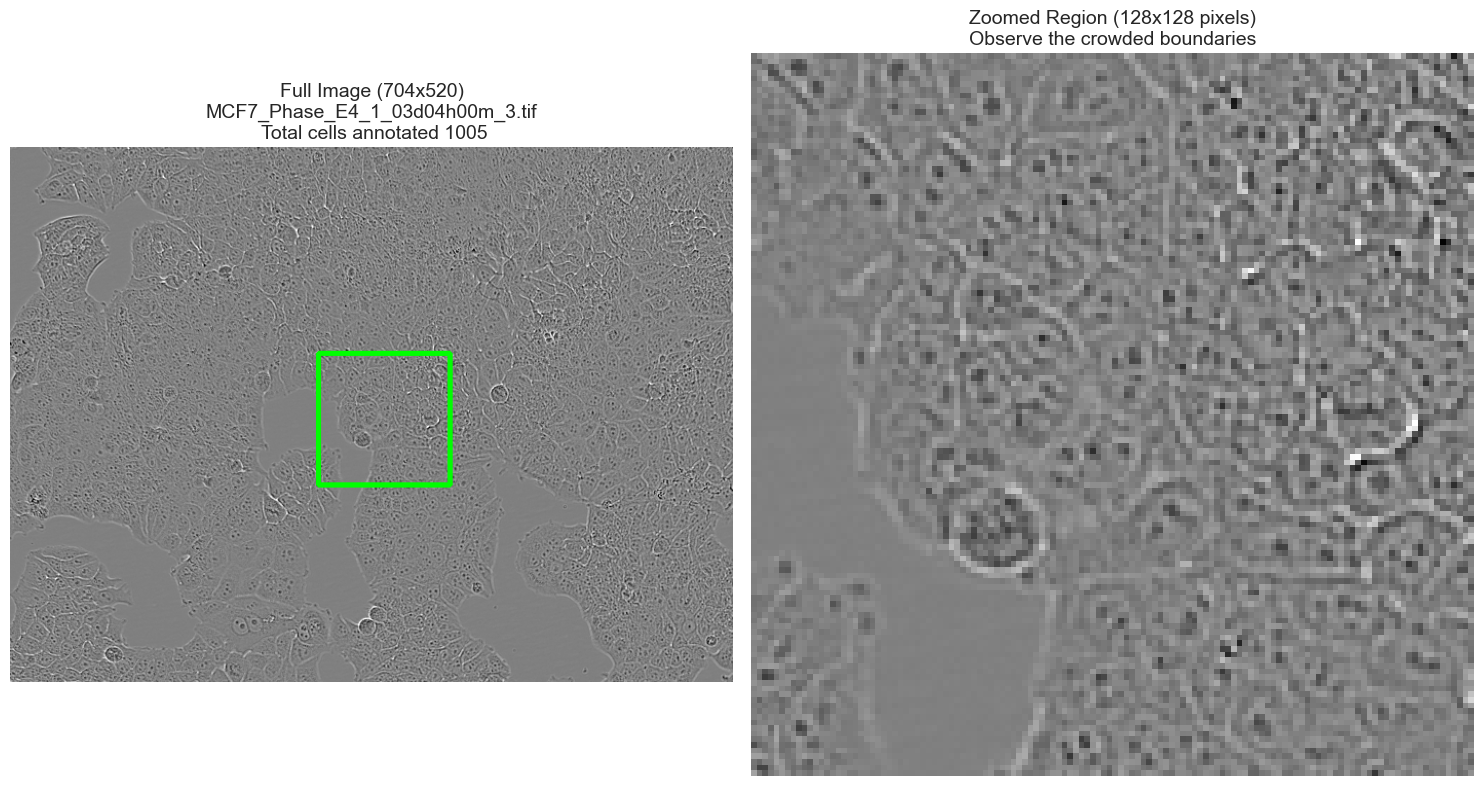

In [10]:
json_path = os.path.join(ANNOTATION_DIR, "livecell_coco_train.json")

print("Loading JSON... (This takes memory!)")
coco = COCO(json_path)

# Containers for stats
cell_counts_per_image = []
cell_areas = []
cell_types_count = defaultdict(int)

img_ids = coco.getImgIds()
print(f"Analyzing {len(img_ids)} images...")

file_with_1000_cells = ""
cell_type = ""
cell_count = 0
for i_id in img_ids:
    # 1. Get basic image info
    img_info = coco.loadImgs(i_id)[0]
    filename = img_info['file_name']
    
    # Identify Cell Type from filename (e.g. 'A172_Phase_...')
    c_type = filename.split('_')[0]
    cell_types_count[c_type] += 1
    
    # 2. Get Annotations for this image
    ann_ids = coco.getAnnIds(imgIds=i_id)
    anns = coco.loadAnns(ann_ids)
    
    # Store Count (Density)
    cell_counts_per_image.append(len(anns))
    if len(anns) >=1000:
        file_with_1000_cells = filename
        cell_type = c_type
        cell_count = len(anns)
        break
        
image = cv2.imread(f'dataset/images 2/livecell_train_val_images/{c_type}/{filename}')
CROP_X = 300  
CROP_Y = 200
CROP_SIZE = 128  # 128x128 pixel window

# 
# Convert from BGR (OpenCV) to RGB (Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Create the zoomed crop
zoomed_crop = image_rgb[CROP_Y:CROP_Y+CROP_SIZE, CROP_X:CROP_X+CROP_SIZE]

# Create a copy of the full image to draw the green box on
# (We do this so we don't permanently modify the original image data)
full_image_with_box = image_rgb.copy()

# Draw a Green Rectangle (0, 255, 0) with thickness 3
cv2.rectangle(full_image_with_box, 
            (CROP_X, CROP_Y), 
            (CROP_X + CROP_SIZE, CROP_Y + CROP_SIZE), 
            (0, 255, 0), 
            3)

# 3. PLOTTING (Side-by-Side)
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Left: Full Image
axes[0].imshow(full_image_with_box)
axes[0].set_title(f"Full Image (704x520)\n{filename}\n Total cells annotated {cell_count}", fontsize=14)
axes[0].axis('off')

# Right: Zoomed Crop
axes[1].imshow(zoomed_crop)
axes[1].set_title(f"Zoomed Region ({CROP_SIZE}x{CROP_SIZE} pixels)\nObserve the crowded boundaries", fontsize=14)
axes[1].axis('off') # Turn off axis numbers for cleaner look

plt.tight_layout()
plt.savefig("problem_visualization.png", dpi=300) # Save high-res for your report
plt.show()


#### The left panel displays a high-density sample. The green box indicates the region of interest. The right panel (zoomed view) reveals the extreme packing of cells. Note that boundaries between cells are often only 1-2 pixels wide. Standard resizing (e.g., downsampling by 50%) would merge these boundaries, making individual counting impossible. This validates the need for our Tiled Processing approach